In [51]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def power_iteration(A, num_simulations: int = 1000, epsilon: float = 1e-10):
    n, _ = A.shape
    b_k = np.random.rand(n)
    b_k = b_k / np.linalg.norm(b_k)
    
    eigenvalue = 0.0
    for _ in range(num_simulations):
        b_k1 = A @ b_k
        b_k1_norm = np.linalg.norm(b_k1)
        if b_k1_norm == 0:
            return 0, b_k
        b_k1 = b_k1 / b_k1_norm
        eigenvalue_new = b_k.T @ A @ b_k
        if np.abs(eigenvalue_new - eigenvalue) < epsilon:
            break
        eigenvalue = eigenvalue_new
        b_k = b_k1
    return eigenvalue, b_k

def deflate_matrix(A, eigenvalue, eigenvector):
    return A - eigenvalue * np.outer(eigenvector, eigenvector)

def get_eigen_pairs(A, max_rank):
    eigvals, eigvecs = [], []
    A_copy = A.copy()
    for _ in range(max_rank):
        eigenvalue, eigenvector = power_iteration(A_copy)
        if eigenvalue < 1e-10:
            break
        eigvals.append(np.sqrt(eigenvalue))
        eigvecs.append(eigenvector)
        A_copy = deflate_matrix(A_copy, eigenvalue, eigenvector)
    return np.array(eigvals), np.array(eigvecs).T  # eigvecs - матрица (n x k)

def compute_svd(A, rank=None):
    m, n = A.shape
    if m >= n:
        # Используем A^T A
        matrix = A.T @ A
        eigvals, V = get_eigen_pairs(matrix, max_rank=n)  # V размер (n x k)
        # Обрезаем по rank, если надо
        if rank is not None:
            eigvals = eigvals[:rank]
            V = V[:, :rank]
        # Собираем Sigma
        Sigma = np.diag(eigvals)
        # Определяем U
        U = A @ V @ np.linalg.pinv(Sigma)
    else:
        # Используем A A^T
        matrix = A @ A.T
        eigvals, U = get_eigen_pairs(matrix, max_rank=m)  # U размер (m x k)
        if rank is not None:
            eigvals = eigvals[:rank]
            U = U[:, :rank]
        Sigma = np.diag(eigvals)
        V = np.linalg.pinv(Sigma) @ U.T @ A  # будет (r x m) @ (m x n) = (r x n)
        V = V.T  # теперь V размер (n x r)

    return U, Sigma, V

def reconstruct_matrix(U, Sigma, V):
    # Теперь V размер (n x r), поэтому для реконструкции A используем V^T
    return U @ Sigma @ V.T

def svd_on_image(image_path, rank=50, show=True):
    image = Image.open(image_path).convert('L')
    A = np.array(image, dtype=float)
    
    # Вычисляем SVD
    U, Sigma, V = compute_svd(A, rank=rank)
    
    # Восстанавливаем изображение
    A_reconstructed = reconstruct_matrix(U, Sigma, V)
    A_reconstructed = np.clip(A_reconstructed, 0, 255)
    reconstructed_image = Image.fromarray(A_reconstructed.astype('uint8'))
    
    if show:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title('Исходное изображение')
        plt.imshow(A, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title(f'Восстановленное изображение (rank={rank})')
        plt.imshow(A_reconstructed, cmap='gray')
        plt.axis('off')
        
        plt.show()
    
    return reconstructed_image

def example_with_matrix():
    A = np.array([[-2, 3, 9, -1],
                  [7, -6, 0, 4],
                  [0, 8, -3, 7]], dtype=float)
    print("Исходная матрица A:")
    print(A)
    
    U, Sigma, V = compute_svd(A)
    print("\nМатрица U:")
    print(U)
    print("\nСингулярные значения Sigma:")
    print(Sigma)
    print("\nМатрица V:")
    print(V)
    
    A_reconstructed = reconstruct_matrix(U, Sigma, V)
    print("\nВосстановленная матрица A:")
    print(A_reconstructed)

# Пример
example_with_matrix()

Исходная матрица A:
[[-2.  3.  9. -1.]
 [ 7. -6.  0.  4.]
 [ 0.  8. -3.  7.]]

Матрица U:
[[ 0.44655446  0.58087492  0.68056839]
 [-0.70468064 -0.24039819  0.66755842]
 [ 0.55137493 -0.77768441  0.30198081]]

Сингулярные значения Sigma:
[[11.80940398  0.          0.        ]
 [ 0.         11.10346443  0.        ]
 [ 0.          0.          7.43310537]]

Матрица V:
[[-0.49332493 -0.25618465  0.44554355]
 [ 0.84498309 -0.27346973  0.0608361 ]
 [ 0.20025273  0.6809521   0.70215244]
 [ 0.05032832 -0.62919628  0.55206146]]

Восстановленная матрица A:
[[-2.00000257e+00  3.00000336e+00  8.99999851e+00 -1.00000034e+00]
 [ 7.00000324e+00 -5.99999907e+00 -5.16732719e-06  4.00000548e+00]
 [ 3.36503164e-06  7.99999542e+00 -2.99999782e+00  7.00000028e+00]]


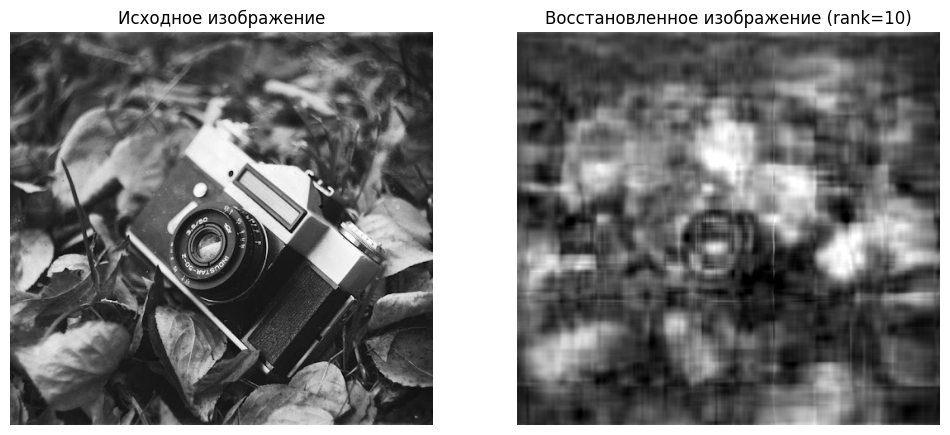

In [50]:
# Запуск с картинкой
image = svd_on_image('photo.jpg', rank=10)